# Fixed Bias Sampler

Gibbs sampler for the reporter model where each weekday is assigned a fixed reporting bias $\alpha_{w[t]}$, which does not vary over time and is independant of other days. This scales the true case/death number on each day to give the recorded count.

## Synthetic Data Generation

Here we use a renewal model to generate synthetic data, which we will subsequently perform inference on.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '12'

from synthetic_data import RenewalModel, Reporter

In [2]:
# Simulate Renewal Model
time_steps = 200; N_0 = 500

model = RenewalModel(R0=0.99)
model.simulate(T=time_steps, N_0=N_0)

100%|██████████| 199/199 [00:00<00:00, 54400.48it/s]


In [3]:
# Report unbiased and biased data
rep = Reporter(model.case_data)
truth_df = rep.unbiased_report()

bias = [0.5, 1.4, 1.2, 1.1, 1.1, 1.1, 0.6]
bias_df = rep.fixed_bias_report(bias=bias, multinomial_dist=True)

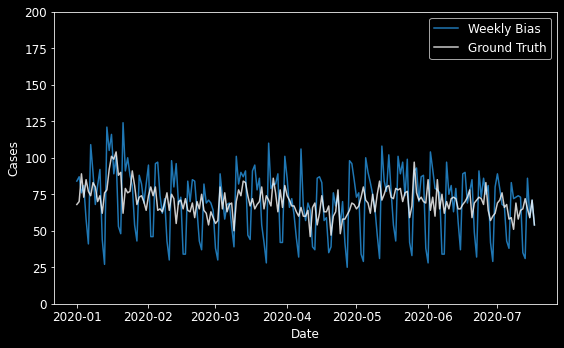

In [4]:
# Plot bias in data
fig, axs = plt.subplots(1, figsize=(8,5))

bias_df.plot(x='Date', y='Confirmed', ax=axs, color='tab:blue', label = 'Weekly Bias')
truth_df.plot(x='Date', y='Confirmed', ax=axs, color='white', label = 'Ground Truth', alpha=0.8)
# fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("Cases")
plt.legend(); plt.ylim(0, 200); plt.tight_layout()
# plt.savefig("../../images/synthetic_examples/"
#             + f"biased_output_T_{time_steps}_N0_{N_0}.png")

## Fixed Bias Formulation

The simplest form of this formulation is when $C_{t} = \alpha_{w[t]} I_{t}$ - i.e. the ground truth cases are scaled by some weekday-dependant scalar constant to give the observed cases. To generate sufficient noise in the periodicity of the observed (recorded) data however, we use $C_{t} \sim Po(\alpha_{w[t]} I_{t})$, while the true cases are still given by the renewal equation $I_{t} \sim Po(R_{t} \Lambda_{t})$.


The parameters are then updated in two steps. First each time step $I_{t}$ is sampled independantly from the following distribution:

$$
P(I_{t} | C_{t}, \alpha_{i}, R_{t}) =  Po(I_{t} | R_{t} \Lambda_{t}) \times Po(C_{t} | \alpha_{i}I_{t})
$$

Secondly, $\alpha_{i}$ are updated using Gibbs sampling from the following conditional probability:

$$
P(\alpha_{i} | I_{t} , C_{t}) = \prod_{1, 8, 15, ...} Po(C_{t} | \alpha_{i} I_{t} ) \times Gamma(\alpha_{i} | a, b)
$$

summing over all days of that given weekday (monday indicies illustrated). This may be simplified to a single Gamma distribution using a known conditional prior relation (noting that the rates of the two processes differ by a scalar $I_{t}$ and so this is not quite equal to the standard relation). The prior of $\alpha_{i}$ is given by a Gamma distribution $Gamma(a, b)$.


### Conjugate Priors for $\alpha_{i}$

As above, the conditional posterior for $\alpha_{i}$ is given by:

$$
P(\alpha_{i} | I_{t} , C_{t}) = \prod_{t} Po(C_{t} | \alpha_{i[t]} I_{t} ) \times Gamma(\alpha_{i} | a, b)
$$

where we only consider times correposnding to a single weekday (i.e. $t = {1, 8, 15...}$ for $i = 1$).

The product may be written as:

$$
\prod_{t} Po(C_{t} | \alpha_{i[t]} I_{t} ) = \prod_{t} (\alpha_{i[t]}I_{t})^{C_{t}} \times \frac{e^{-\alpha_{i[t]} I_{t}}}{C_{t}!}
$$

which we may simplify to (also removing the constant factorial $C_{t}!$):

$$
\prod_{t} Po(C_{t} | \alpha_{i[t]} I_{t} ) \propto \alpha_{i[t]} \! ^{\sum_{t=i}^{n}C_{t}} \times e^{-\alpha_{i[t]} \sum_{t=i}^{n}I_{t}} \times \prod_{t} I_{t}^{C_{t}}
$$

Combining this with the explicit form of the gamma prior, we may therefore write that:

$$
P(\alpha_{i} | I_{t} , C_{t}) \propto \alpha_{i[t]} \! ^{\sum_{t=i}^{n}C_{t}} \times e^{-\alpha_{i[t]} \sum_{t=i}^{n}I_{t}} \times \alpha_{i[t]} \! ^{a-1} \times e^{-b\alpha_{i[t]}} \times \prod_{t} I_{t}^{C_{t}} 
$$

Collecting like terms, and removing the multiplicative constant $\prod_{t} I_{t}^{C_{t}}$, we arrive at the final result:

$$
P(\alpha_{i} | I_{t} , C_{t}) \propto \alpha_{i[t]} \! ^{(a + \sum_{t=i}^{n}C_{t}) - 1} \times e^{ - \alpha_{i[t]} \left(b + \sum_{t=i}^{n}I_{t}\right)}
$$

which is in the form of a Gamma distribution:

$$
P(\alpha_{i} | I_{t} , C_{t}) \sim Gamma \left(a + \sum_{t=i}^{n}C_{t}, b + \sum_{t=i}^{n}I_{t} \right)
$$


In [5]:
from sampling_methods import GibbsParameter, MixedSampler
from synthetic_data import RenewalModel

In [6]:
def truth_likelihood(params, index, value):
    """The independant probability of a given value for a given index of truth time series."""
    prob_truth = ss.poisson.pmf(k=value,
                                mu=_calculate_gamma(params, index) * params['R_t'])

    prob_measurement = ss.poisson.pmf(k=params['data_' + str(index)],
                                      mu=(params['bias_' + str(index % 7)] 
                                          * params['truth_' + str(index)]))
        
        # Assumes week starts on a monday, otherwise can convert later
    return prob_truth * prob_measurement

def _calculate_gamma(params, max_t):
    """Historic gama factor for a given index of data series"""
    omega = RenewalModel(R0=params['R_t']).serial_interval
    cases = [params[k] for k in params.keys() if k.startswith('data_')]
    n_terms_gamma = min(max_t + 1, len(omega))  # Number of terms in sum for gamma
    return sum([omega[i] * cases[-i] for i in range(1, n_terms_gamma)])

def truth_sample(params, index):
    weights = []
    values = range(max(150, 2 * params['data_' + str(index)]))
    for val in values:
        # Checks values from 0 to 2 * current value
        # Safeguard that it should check up to 150 at least in case current value is poor
        weights.append(truth_likelihood(params, index, val)) # for value
    
    return np.random.choice(a=values, p=(weights / sum(weights)))

In [7]:
def bias_pdf_params(index, value, **kwargs):
    """Parameters for the probability density function (pdf) for 
    a given index of the bias vector."""
    # params = locals()  # Collect kwargs back into one params dictionary
    params = kwargs

    data_indicies = [k[len('data_'):] for k in sorted(params.keys()) if k.startswith('data_')]
    data_values = []; truth_values = []

    for i in data_indicies:
        if int(i) % 7 == index:
            data_values.append(params['data_' + str(i)])
            truth_values.append(params['truth_' + str(i)])

    gamma_params = {'a': params['bias_prior_alpha'] + sum(data_values),
                   'scale': 1 / (params['bias_prior_beta'] + sum(truth_values)),
                   'x': value}  # scale is inverse of beta value
    return gamma_params

In [8]:
def bias_parameter(value, index):
    """Creates Gibbs parameter object, with a gamma posterior derived
    using conjugate priors above. Function object is created for the
    correct index, and can be passed the unpacked params dictionary."""
    return GibbsParameter(
        value=value, conditional_posterior=ss.gamma.pdf,
        posterior_params = lambda **kwargs : bias_pdf_params(index=index, value=value, **kwargs))

def truth_parameter(value, index):
    """Creates parameter object for a single data point of known index 
    in truth array. 

    Uses Gibbs framework, but samples next values indepedently, rather 
    than from the conditional distribution (the sample method of the
    parameter is overwritten to allow this).
    """
    param = GibbsParameter(value=value, conditional_posterior=None)
    # overwrite sampling method for parameter to use independant sampling
    param.sample = lambda params : truth_sample(params, index=index)
    return param

In [9]:
I_data = list(bias_df['Confirmed'])
params = {'bias_prior_alpha': 1, 'bias_prior_beta': 1}  # Gamma dist

params['R_t'] = 0.99  # Start with known R_t

for i, val in enumerate(I_data):  # Observed cases - not a Parameter
    params[("data_" + str(i))] = val

data_initial_guess = sum(I_data)/len(I_data)  # Constant initial value
for i in range(len(I_data)):  # Ground truth data
    params[("truth_" + str(i))] = truth_parameter(data_initial_guess, index=i)

for i in range(7):  # Weekday bias parameters
    params[("bias_" + str(i))] = bias_parameter(1, index=i)

sampler = MixedSampler(params=params)
output = sampler.sampling_routine(step_num=200)

# still having issues with initial condition - means data is much lower than truth.

100%|██████████| 200/200 [2:34:28<00:00, 46.34s/it]  


Mean bias values: 7.2e-41, 7.7e-24, 4.9e-13, 1e-16, 2.8e-17, 1.1e-60, 1.6e-85, 

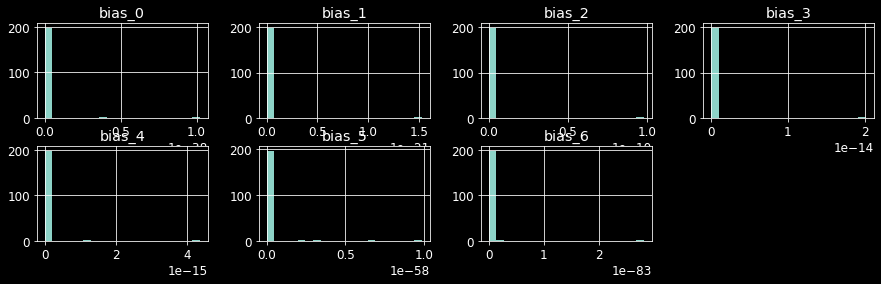

In [10]:
output.hist([("bias_" + str(i)) for i in range(7)], bins=20, figsize=(15, 4), layout=(2,4));
print('Mean bias values: ', end = '')
for i in range(7):
    bias  = 'bias_' + str(i)
    print(f"{np.mean(output[bias]):.2g}", end = ', ',)

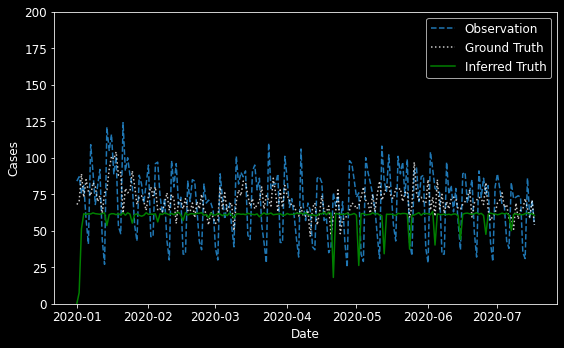

In [13]:
data_keys = [k for k in sorted(params.keys()) if k.startswith('truth_')]
predicted_truth = []
for key in data_keys:
    predicted_truth.append(np.mean(output[key]))

# Plot bias in data
fig, axs = plt.subplots(1, figsize=(8,5))

bias_df.plot(x='Date', y='Confirmed', ax=axs, color='tab:blue', label = 'Observation', linestyle = 'dashed')
truth_df.plot(x='Date', y='Confirmed', ax=axs, color='white', label = 'Ground Truth', alpha=0.8, linestyle = 'dotted')
axs.plot(truth_df['Date'], predicted_truth, color='green', label = 'Inferred Truth')
# fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("Cases")
plt.legend(); plt.ylim(0, 200); plt.tight_layout()
plt.savefig("../images/synthetic_inference/"
            + f"biased_reconstruction_T_{time_steps}_N0_{N_0}.png")